# Modules import

In [4]:
# Standard libraries
import sys
import time
import os
import warnings

# Data Analysis Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import curve_fit

# Machine Learning Libraries
from sklearn.decomposition import PCA  # Dimensionality reduction
from sklearn.metrics import ( 
    balanced_accuracy_score as bal_accuracy,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score
) # Classification metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier

# PyTorch Libraries
import torch
from torch import nn, optim
from torchinfo import summary
from torchmetrics.classification import Accuracy  # Classification accuracy metric
from torch.utils.data import TensorDataset, DataLoader  # Dataset and data loader utilities

# Hardware Monitoring library from "openhwmonitor.py"
from openhwmonitor import OpenHWMonitor, OpenHWMonitor_stats  
hw_monitor = OpenHWMonitor()

# SciServer library from "sciservercom.py"
from sciservercom import SciServer

# CUDA device check
device = "cuda" if torch.cuda.is_available() else "cpu"  
print(f"Computation device: {device}\n") 

Computation device: cuda



# SciServer Data Requests

## SciServer Connection

In [ ]:
sciserver = SciServer(isEnabled=False)
sciserver.loginFromEnv()

## Query Requests

In [7]:
table_name = "DR17_table"
query_context = "DR17"
table_size = 4618753  # max avaiable data for DR17_table
my_context = 'MyDB'

main_query = f"""
SELECT TOP {table_size}
    p.ra AS ra, 
    p.dec AS dec, 
    p.u AS u, 
    p.g AS g, 
    p.r AS r, 
    p.i AS i, 
    p.z AS z, 
    s.spectroFlux_u AS spec_u,
    s.spectroFlux_g AS spec_g,
    s.spectroFlux_r AS spec_r,
    s.spectroFlux_i AS spec_i,
    s.spectroFlux_z AS spec_z,
    s.elodieTEff AS teff,
    s.elodieFeH AS metalliticy,
    s.elodieSpType AS spectclass,
    s.z AS redshift,
    s.class AS class
INTO {my_context.lower()}.{table_name}
FROM 
    PhotoObj AS p 
JOIN 
    SpecObj AS s 
    ON s.bestobjid = p.objid
WHERE 
    p.ra BETWEEN 0 AND 360 AND p.dec BETWEEN -90 AND 90
ORDER BY NEWID()
"""

In [ ]:
sciserver.queryRequest(main_query, table_name, query_context)

In [6]:
df = sciserver.downloadTable(f"SELECT * FROM {table_name}", my_context)
df.to_csv(f"{table_name}.csv", index=False)

# Utils Tables Definition

In [3]:
# "Model" Table to store model information
models_name = ['Random Forest', 'XGBoost', 'Multilayer Perceptron', "Tabular Transformer"]
models_id = range(len(models_name))

model_dict = { 'Model_ID' : models_id, "Model_Name" : models_name }

model_table = pd.DataFrame(data = model_dict)
model_table.to_csv("model_table.csv", index=False)
                           
# free up memory
del model_table, model_dict, models_name

In [76]:
# "Test" Table to store model performance
test_table_columns = ['Model_ID', 'Accuracy', 'F1_Score', 
                      'Galaxy_Pred', 'Star_Pred', 'Quasar_Pred']
test_table = pd.DataFrame(columns = test_table_columns)

def testTableUpdate(model_id, acc, f1, c_mat):
    # Extracts predictions from the confusion matrix
    predictions = []
    for i in range(len(labels)):
        predictions.append(c_mat[i,i])
    # Adds a new row
    test_table.loc[len(test_table)] = [model_id,
                                       acc,
                                       f1,
                                       predictions[0],
                                       predictions[1],
                                       predictions[2]] 
    test_table[test_table_columns[0]] = test_table[test_table_columns[0]].astype('int8')

In [72]:
# "Train" Table to store model training info
train_table_columns = ['Model_ID', 'Train_Time', 
                       'Train_Score', 'Valid_Score', 
                       'Train_Loss', 'Valid_Loss']
train_table = pd.DataFrame(columns = train_table_columns)

def trainTableUpdate(model_id, train_time, train_score, valid_score, train_loss=0, valid_loss=0):
    # Adds a new row
    train_table.loc[len(train_table)] = [model_id, 
                                         train_time,
                                         train_score, 
                                         valid_score,
                                         train_loss,
                                         valid_loss]     
    train_table[train_table_columns[0]] = train_table[train_table_columns[0]].astype('int8')

In [73]:
# "Measure" Table to store hardware info during training
measure_table = pd.DataFrame(columns = ['Model_ID'] + [k for k in OpenHWMonitor_stats().to_dict()])

def measureTableUpdate(model_id, hw_data):
    for i in range(len(next(iter(hw_data.items()))[1])):
        # Adds a new row
        measure_table.loc[len(measure_table)] = [model_id,
                                                 hw_data['CPU_Power'][i],
                                                 hw_data['CPU_Usage'][i],
                                                 hw_data['CPU_Temp'][i],
                                                 hw_data['GPU_Power'][i],
                                                 hw_data['GPU_Usage'][i],
                                                 hw_data['GPU_Temp'][i],
                                                 hw_data['Elapsed_Time'][i]] 
    measure_table['Model_ID'] = measure_table['Model_ID'].astype('int8')

# Data Loading and Exploration

In [2]:
df = pd.read_csv('DR17_table.csv')#, nrows=100000)

# Drops irrelevant features (specifically those related to STAR class)
df = df.drop(columns=['spectclass', 'teff', 'metalliticy'])

df.sample(5)

ra        dec         u         g         r         i  \
2647133    6.984113  -0.374027  24.67030  23.24225  21.70627  20.51275   
2623799  119.820320  10.247229  23.14392  21.03630  19.23164  18.51936   
1853733   40.914853   4.250850  21.90823  21.64240  21.36388  21.45176   
983221   172.494360  37.274456  24.93339  21.77454  21.01840  20.93597   
3826327    8.388419  -0.068708  20.21178  19.84338  19.63802  19.47743   

                z     spec_u     spec_g     spec_r     spec_i     spec_z  \
2647133  19.81469   0.408531   0.198172   1.315839   4.444504   8.229394   
2623799  18.15506   0.476509   1.400638   6.886958  13.135680  18.658790   
1853733  21.61579   0.113512   1.876468   2.530298   3.055308   5.087689   
983221   20.59292   0.683692   2.135018   4.017195   4.879900   5.210853   
3826327  19.21890  10.588980  10.774440  12.261520  14.360520  19.174350   

         redshift   class  
2647133  0.731295  GALAXY  
2623799  0.421359  GALAXY  
1853733  1.246727     QSO  
983221  -0.000153    STAR  
3826327  2.062890     QSO

## Preprocessing

In [3]:
# defines label column and extracts unique labels
label_col = 'class'
labels = df[label_col].unique()
# all feature columns
feature_cols = list(df.iloc[:,2:-1].columns)
# photometric feature columns
photo_cols = list(df.iloc[:,2:-7].columns)
# spectroscopic feature columns
spect_cols = list(df.iloc[:,7:-1].columns)

print("dataframe shape:",df.shape)

# value counts for each class (GALAXY, STAR, Q (QUASAR))
display(df[label_col].value_counts().to_frame().style.bar(color='green'))

# defines a colormap for the classes
cmap = colors.ListedColormap(['blue', 'black', 'red'], name = label_col)

# descriptive statistics for the photometric and spectroscopic columns
display(df[photo_cols].describe())
display(df[spect_cols].describe())

dataframe shape: (4618753, 14)


u             g             r             i             z
count  4.618753e+06  4.618753e+06  4.618753e+06  4.618753e+06  4.618753e+06
mean   2.176593e+01  2.032740e+01  1.940044e+01  1.879850e+01  1.846735e+01
std    5.501987e+01  5.380522e+01  4.734750e+01  5.109344e+01  5.235223e+01
min   -9.999000e+03 -9.999000e+03 -9.999000e+03 -9.999000e+03 -9.999000e+03
25%    2.031426e+01  1.890839e+01  1.805858e+01  1.765728e+01  1.739105e+01
50%    2.217223e+01  2.108996e+01  2.011213e+01  1.939030e+01  1.898897e+01
75%    2.368100e+01  2.212921e+01  2.103545e+01  2.037768e+01  1.990430e+01
max    3.345042e+01  3.372469e+01  3.384567e+01  3.234917e+01  3.084678e+01

spec_u        spec_g        spec_r        spec_i        spec_z  \
count  4.618753e+06  4.618753e+06  4.618753e+06  4.618753e+06  4.618753e+06   
mean   1.027277e+01  2.458748e+01  4.710419e+01  6.382916e+01  7.777971e+01   
std    1.302282e+02  5.403264e+02  1.284060e+03  1.827233e+03  2.373641e+03   
min   -1.119229e+03 -9.406096e+02 -8.654229e+02 -8.654229e+02 -9.803539e+02   
25%    3.037290e-01  7.596362e-01  2.594236e+00  5.162067e+00  7.400746e+00   
50%    1.465635e+00  2.617656e+00  6.121053e+00  1.046706e+01  1.521673e+01   
75%    6.342019e+00  1.437006e+01  2.948215e+01  4.238084e+01  5.368458e+01   
max    1.093949e+05  4.862328e+05  1.058207e+06  1.435664e+06  1.915441e+06   

           redshift  
count  4.618753e+06  
mean   5.773373e-01  
std    7.286075e-01  
min   -1.144691e-02  
25%    6.259261e-02  
50%    4.272459e-01  
75%    7.039943e-01  
max    7.051930e+00

### Outlier removal

In [4]:
# function to remove outliers based on std. deviation
def remove_outliers_sigma(df, cols, sigma=5):
    df_cleaned = df.copy()
    for col in cols:
        mean = df_cleaned[col].mean()
        std = df_cleaned[col].std()
        mask = (df_cleaned[col] >= mean - sigma * std) & (df_cleaned[col] <= mean + sigma * std)
        df_cleaned = df_cleaned[mask]
    return df_cleaned

# function to remove outliers based on IQR
def remove_outliers_iqr(df, cols, k=1.5):
    df_cleaned = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        mask = (df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)
        df_cleaned = df_cleaned[mask]
    return df_cleaned

In [5]:
df = remove_outliers_sigma(df, photo_cols)
df = remove_outliers_sigma(df, spect_cols)

print(df.shape)
display(df[label_col].value_counts().to_frame().style.bar(color='green'))

(4464925, 14)


### Label Encoding

In [6]:
# labels dictionary for label encodig
cls_dict = {}
for i_cls, cls in enumerate(labels):
    cls_dict.update( { cls : i_cls } )
     # label encoding
    df.loc[ df.loc[:, label_col] == cls, label_col ] = i_cls  

# converts dataframe label column to int
df[label_col] = df[label_col].astype('int8')

# defines labels dict to map dataframe for visualizzation
df_cls_dict = {i_cls : cls for cls, i_cls in cls_dict.items()}

print(cls_dict)

{'GALAXY': 0, 'STAR': 1, 'QSO': 2}


### Normalization

In [7]:
# Min-Max Normalization
df.iloc[:,:-1] = (df.iloc[:,:-1] - df.iloc[:,:-1].min())/(df.iloc[:,:-1].max() - df.iloc[:,:-1].min())
# Z-Score Normalization
# df.iloc[:,:-1] = (df.iloc[:,:-1] - df.iloc[:,:-1].mean()) / df.iloc[:,:-1].std()

## Features Visualization

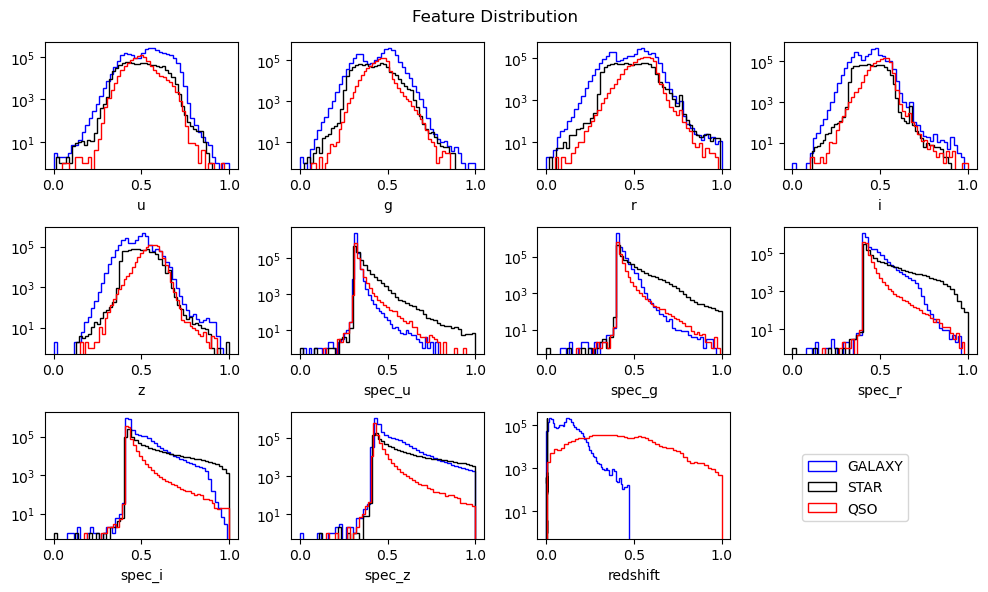

In [9]:
fig = plt.figure(figsize=(10,6))
fig.suptitle("Feature Distribution")

for i, c in enumerate(feature_cols):
    plt.subplot(3, 4, i+1)
    for l, label in enumerate(labels):
        plt.hist(df[df[label_col].map(df_cls_dict) == label][c], color=cmap.colors[l], bins=50, histtype='step', label=label)
    plt.yscale('log')    
    plt.xlabel(c)
    plt.legend().remove()
    
fig.legend(labels, bbox_to_anchor=(0.92, 0.25))
plt.tight_layout()
plt.show()

In [10]:
# features correlation
df[feature_cols].corr().style.background_gradient(cmap='RdBu_r')

In [11]:
# plot the classes onto a sphere projection of RA and DEC celestial coordinates
plot3d_limit = 10000 # number of element to plot
plot3d_offset = 0

eps = 1e-8

ra = df.iloc[plot3d_offset:plot3d_limit + plot3d_offset,0] * 2 * np.pi
dec = (df.iloc[plot3d_offset:plot3d_limit + plot3d_offset,1] - 0.5) * np.pi
# use redshift as distance from center
red = 1 # df.loc[plot3d_offset:plot3d_limit + plot3d_offset, 'redshift']

fig = px.scatter_3d(x = red * np.cos(dec) * np.cos(ra), 
                    y = red * np.cos(dec) * np.sin(ra), 
                    z = red * np.sin(dec),
                    color = df.iloc[plot3d_offset:plot3d_limit + plot3d_offset, -1].map(df_cls_dict),
                    color_discrete_map = { df_cls_dict[cls] : cmap.colors[cls] for cls in df_cls_dict })

fig.update_layout(
    autosize=False,
    width=600, 
    height=600,
    margin=dict(l=30,r=30,b=30,t=30,pad=4), 
    scene = dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    paper_bgcolor="white", 
    scene_aspectmode='cube',
    legend_title="Class",
    legend=dict(tracegroupgap=0, itemsizing='constant'),
    title='Unitary sphere projection of Classes from RA and DEC'
)
fig.update_traces(marker=dict(size=2))
fig.update_layout(legend=dict(itemwidth=30, tracegroupgap=10))
fig.show()

### PCA - Dimensionality Reduction

Explained variance comp. 1 -> 0.626464640180104
Explained variance comp. 2 -> 0.23575745816653385
Explained variance comp. 3 -> 0.06982836743765278
Sum of explained varianca for 3 components -> 0.9320504657842905


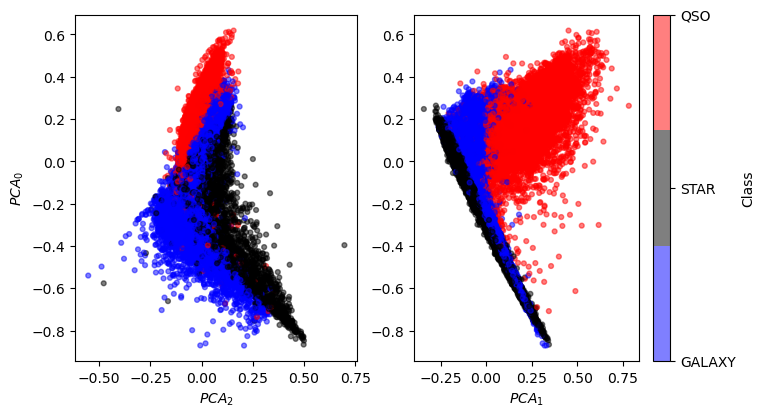

In [57]:
pca_features = df.drop(columns=[ 'ra', 'dec', label_col])
pca_labels = df[label_col]

# pca with 3 components (usefull for 3d plot)
pca = PCA(3)
x_cls_pca = pca.fit_transform(pca_features)
pca_var = pca.explained_variance_ratio_

for i in range(0, len(pca_var)):
    print(f"Explained variance comp. {i+1} -> {pca_var[i]}")
print(f"Sum of explained varianca for {i+1} components -> {pca_var.sum()}")

plot_limit = 50000 # number of element to plot
plt.figure(figsize=(8, 4.5))

ax = plt.subplot(1,2,1)
sc1 = plt.scatter(x_cls_pca[:plot_limit,2], x_cls_pca[:plot_limit,0], c=pca_labels[:plot_limit], cmap=cmap, alpha=0.5, s=12)
plt.xlabel("${PCA}_2$")
plt.ylabel("${PCA}_0$")

ax = plt.subplot(1,2,2)
sc1 = plt.scatter(x_cls_pca[:plot_limit,1], x_cls_pca[:plot_limit,0], c=pca_labels[:plot_limit], cmap=cmap, alpha=0.5, s=12)
plt.xlabel("${PCA}_1$")

cbar = plt.colorbar(sc1, label='Class')
cbar.set_ticks(list(cls_dict.values())) 
cbar.set_ticklabels(list(cls_dict.keys())) 

plt.show()

#### 3D Plot

In [58]:
plot3d_limit = 10000 # number of element to plot
plot3d_offset = 0
fig = px.scatter_3d(x = x_cls_pca[plot3d_offset:plot3d_limit + plot3d_offset,0], 
                    y = x_cls_pca[plot3d_offset:plot3d_limit + plot3d_offset,1], 
                    z = x_cls_pca[plot3d_offset:plot3d_limit + plot3d_offset,2],
                    color = df.iloc[plot3d_offset:plot3d_limit + plot3d_offset, -1].map(df_cls_dict),
                    color_discrete_map = { df_cls_dict[cls] : cmap.colors[cls] for cls in df_cls_dict})

fig.update_layout(
    autosize=False,
    width=600, 
    height=400,
    margin=dict(l=30,r=30,b=30,t=30,pad=4), 
    scene = dict(xaxis_title='PCA0', yaxis_title='PCA1', zaxis_title='PCA2'),
    paper_bgcolor="white", 
    scene_aspectmode='cube',
    legend_title="Class",
    legend=dict(tracegroupgap=0, itemsizing='constant' )
)
fig.update_traces(marker=dict(size=2))
fig.update_layout(legend=dict(itemwidth=30, tracegroupgap=10))
fig.show()

# Data Split and Class Weighting

In [108]:
# sets training size
train_size = 0.75
# sets fixed random seed for reproducibility
seed = 42

# splits dataframe into training and testing sets
df_train, df_test = train_test_split(df.drop(columns=[ 'ra', 'dec']), 
                                     train_size = train_size, 
                                     random_state = seed)

# initializes class weights dictionary
cls_w = {}
# gets number of samples in training data
cls_count = df_train[label_col].shape[0]

# iterates through unique classes
for cls in df_train[label_col].unique():
    # calculates class weight as TOT_Class / N_Class
    cls_w.update(dict( { cls :  cls_count / (df_train[ df_train[label_col] == cls ].shape[0]) } ))
    print(f'weight for { df_cls_dict[cls] }: \t{ "{:1.5f}".format(cls_w[cls]) }')

# converts class weights to numpy array
np_cls_w = np.array([v for k,v in cls_w.items()])

# converts to pytorch tensor for neural networks
cls_w_pt = torch.tensor(np_cls_w).float() 
cls_w_pt = cls_w_pt.to(device) 

print(f"\nTrain size: {df_train.shape}")
display(df_train[ label_col ].map(df_cls_dict).value_counts().to_frame().style.bar(color='green'))

print(f"\nTest size: {df_test.shape}")
display(df_test[ label_col ].map(df_cls_dict).value_counts().to_frame().style.bar(color='green'))

x_cls_train = df_train.loc[:,feature_cols].to_numpy()
y_cls_train = df_train.loc[:,label_col].to_numpy()

x_cls_test = df_test.loc[:,feature_cols].to_numpy()
y_cls_test = df_test.loc[:,label_col].to_numpy()

# free memory up
del df_train, df_test

valid_score = 0
train_score = 0

weight for GALAXY: 	1.61318
weight for QSO: 	5.23328
weight for STAR: 	5.29036

Train size: (3348693, 12)



Test size: (1116232, 12)


# Classification

## Ensemble Method - Random Forest

### Train


Starting fold number 1
time: 26.5s;	train score: 0.998;	valid score: 0.979

Starting fold number 2
time: 26.3s;	train score: 0.998;	valid score: 0.980

Starting fold number 3
time: 26.4s;	train score: 0.998;	valid score: 0.979

Starting fold number 4
time: 26.2s;	train score: 0.998;	valid score: 0.979

Starting fold number 5
time: 26.5s;	train score: 0.998;	valid score: 0.979

Starting fold number 6
time: 26.4s;	train score: 0.998;	valid score: 0.979

Starting fold number 7
time: 26.3s;	train score: 0.998;	valid score: 0.979

Starting fold number 8
time: 26.8s;	train score: 0.998;	valid score: 0.979

mean train score: 0.9978 ± 0.0000
mean valid score: 0.9794 ± 0.0002

total time: 211.47 s


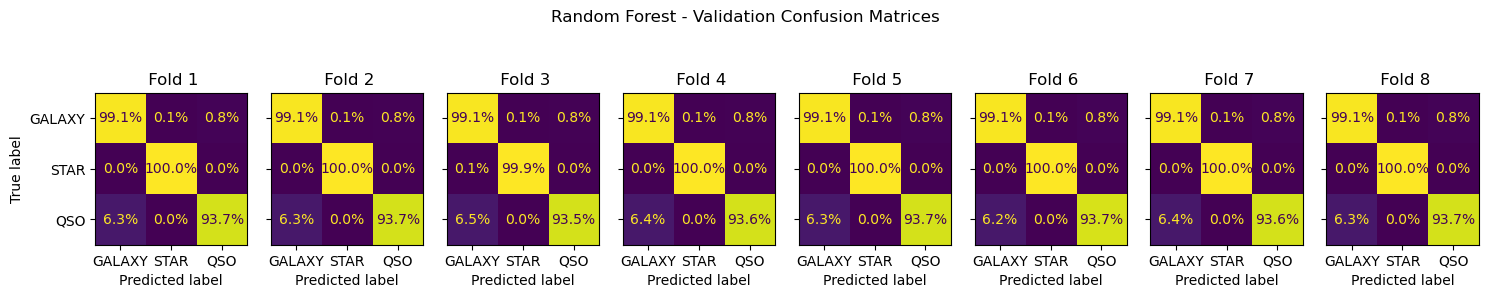

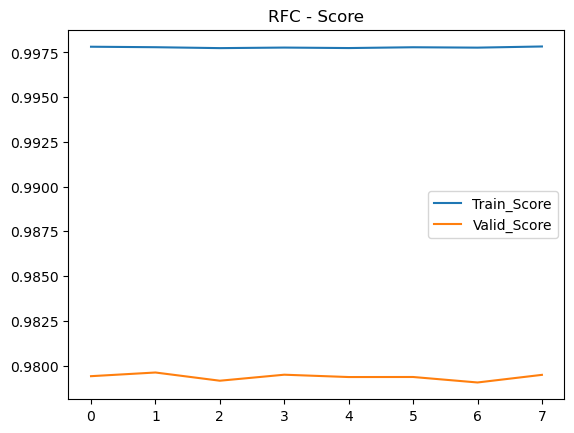

In [74]:
# sets model ID for train, measure and test tables
model_id = 0
# sets number of folds
n_folds = 8

# lists to store training and validation scores and train time
train_score = []
valid_score = []
epoch_times = []

# stratified k-fold cross-validation for unbalanced dataset
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# initializes random forest classifier
rfc_model = RFC(n_estimators=10, class_weight=cls_w, criterion='entropy', n_jobs=-1, random_state=seed)

# figure and axes for validation confusion matrices
fig, axs = plt.subplots(1, n_folds, figsize=(7 + n_folds, 3), sharey=True)
fig.suptitle('Random Forest - Validation Confusion Matrices', ha='center')

# starts hardware monitoring
hw_monitor.start_monitoring()

# folds iteration
for fold, (train_idx, valid_idx) in enumerate(kf.split(x_cls_train, y_cls_train)):
    print('\033[01m' + f"\nStarting fold number {fold+1}" + '\033[0m')    
    t0 = time.time()

    # splits training data into training and validation sets for current fold
    x_train_fold, y_train_fold = x_cls_train[train_idx], y_cls_train[train_idx]
    x_valid_fold, y_valid_fold = x_cls_train[valid_idx], y_cls_train[valid_idx]

    rfc_model.fit(x_train_fold, y_train_fold)
        
    # training and validation macro F1 score
    train_score.append(f1_score(y_train_fold, rfc_model.predict(x_train_fold), average='macro'))
    valid_score.append(f1_score(y_valid_fold, rfc_model.predict(x_valid_fold), average='macro'))
    
    epoch_times.append(time.time()-t0)
    print(f'time: {epoch_times[-1]:.1f}s;\ttrain score: {train_score[-1]:.3f};\tvalid score: {valid_score[-1]:.3f}')

    # updates train table
    trainTableUpdate(model_id, np.array(epoch_times).sum(), train_score[-1], valid_score[-1])
    
    # creates confusion matrix and displays it on subplot
    c_mat = confusion_matrix(y_valid_fold, rfc_model.predict(x_valid_fold), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=c_mat, display_labels=cls_dict.keys())
    disp.plot(values_format='.1%', ax = axs[fold])
    disp.ax_.set_title(f' Fold {fold+1}')
    disp.im_.colorbar.remove()
    if fold > 0:
        disp.ax_.set_ylabel('')

# stops hardware monitoring and updates measure table
hw_monitor.stop_monitoring()
hw_data = hw_monitor.get_stats()
measureTableUpdate(model_id, hw_data)  

print(f"\nmean train score: {np.mean(train_score):.4f} ± {np.std(train_score):.4f}")
print(f"mean valid score: {np.mean(valid_score):.4f} ± {np.std(valid_score):.4f}")
print(f"\ntotal time: {np.array(epoch_times).sum():.2f} s")
plt.tight_layout()
plt.show()  

train_table[ train_table.Model_ID == model_id ][['Train_Score', 'Valid_Score']].plot()
plt.title("RFC - Score")
plt.show()

### Test

0.9792963098376144 0.9755085059940799


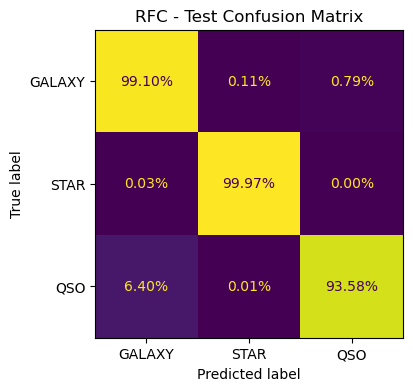

In [77]:
# makes predictions on test data
predictions = rfc_model.predict(x_cls_test)
truths = y_cls_test

# macro F1 score and balanced accuracy on test data
f1_macro = f1_score(truths, predictions, average='macro')
accuracy = bal_accuracy(truths, predictions)

print(f1_macro, accuracy)

# confusion matrix for test data
c_mat = confusion_matrix(truths, predictions, normalize='true')

# updates test table
testTableUpdate(model_id, accuracy, f1_macro, c_mat)

fig, axs = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=c_mat, display_labels=cls_dict.keys())
disp.plot(values_format='.2%', ax = axs)
disp.ax_.set_title('RFC - Test Confusion Matrix')
disp.im_.colorbar.remove()
plt.show()

## Gradient Boosting - XGBoost

### Train


Starting fold number 1
time: 13.4s;	train score: 0.980;	valid score: 0.979

Starting fold number 2
time: 16.7s;	train score: 0.980;	valid score: 0.980

Starting fold number 3
time: 18.0s;	train score: 0.980;	valid score: 0.979

Starting fold number 4
time: 17.7s;	train score: 0.980;	valid score: 0.979

Starting fold number 5
time: 14.8s;	train score: 0.980;	valid score: 0.979

Starting fold number 6
time: 13.2s;	train score: 0.980;	valid score: 0.979

Starting fold number 7
time: 13.1s;	train score: 0.980;	valid score: 0.979

Starting fold number 8
time: 13.0s;	train score: 0.980;	valid score: 0.979

mean train score: 0.9800 ± 0.0001
mean valid score: 0.9791 ± 0.0003

total time: 119.78 s


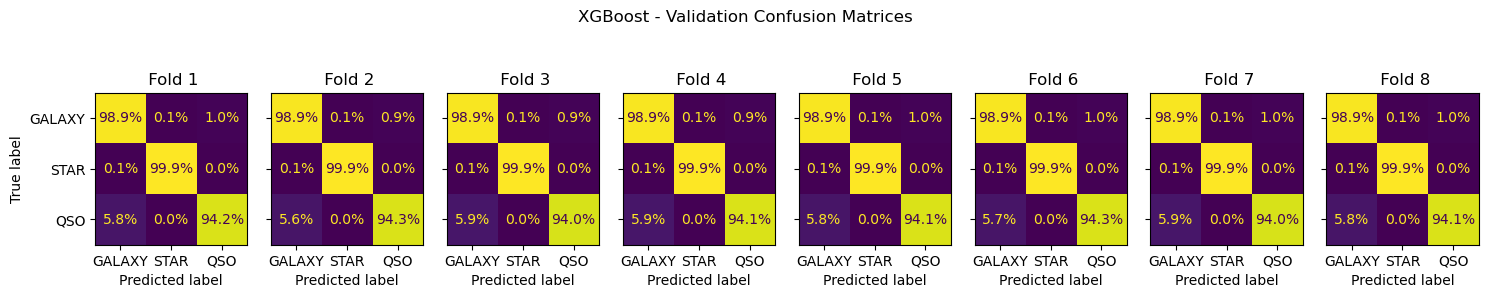

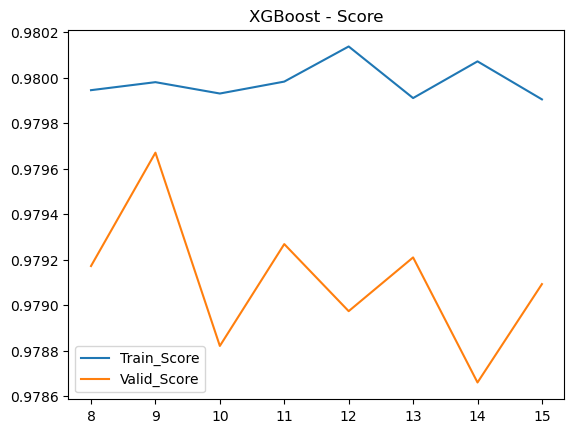

In [78]:
xgb_weights = np.ones(y_cls_train.shape[0], dtype = 'float')
cls_w_np = [v for k,v in cls_w.items()]
for i, val in enumerate(y_cls_train):
    xgb_weights[i] = cls_w_np[val]

# sets model ID for train, measure and test tables
model_id = 1
# sets number of folds
n_fold = 8

# lists to store training and validation scores and train time
train_score = []
valid_score = []
epoch_times = []

# stratified k-fold cross-validation for unbalanced dataset
kf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

# initializes xgboost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss', feature_weights=xgb_weights, n_jobs=-1, random_state=seed)

# figure and axes for validation confusion matrices
fig, axs = plt.subplots(1, n_fold, figsize=(7 + n_fold, 3), sharey=True)
fig.suptitle('XGBoost - Validation Confusion Matrices', ha='center')

# starts hardware monitoring
hw_monitor.start_monitoring()

# folds iteration
for fold, (train_idx, valid_idx) in enumerate(kf.split(x_cls_train, y_cls_train)):    
    print('\033[01m' + f"\nStarting fold number {fold+1}" + '\033[0m')      
    t0 = time.time()

    # splits training data into training and validation sets for current fold
    x_train_fold, y_train_fold = x_cls_train[train_idx], y_cls_train[train_idx]
    x_valid_fold, y_valid_fold = x_cls_train[valid_idx], y_cls_train[valid_idx]

    xgb_model.fit(x_train_fold, y_train_fold)
        
    # training and validation macro F1 score
    train_score.append(f1_score(y_train_fold, xgb_model.predict(x_train_fold), average='macro'))
    valid_score.append(f1_score(y_valid_fold, xgb_model.predict(x_valid_fold), average='macro'))
    
    epoch_times.append(time.time()-t0)
    print(f'time: {epoch_times[-1]:.1f}s;\ttrain score: {train_score[-1]:.3f};\tvalid score: {valid_score[-1]:.3f}')
    
    # tables update
    trainTableUpdate(model_id, np.array(epoch_times).sum(), train_score[-1], valid_score[-1])

    # creates confusion matrix and displays it on subplot
    c_mat = confusion_matrix(y_valid_fold, xgb_model.predict(x_valid_fold), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=c_mat, display_labels=cls_dict.keys())
    disp.plot(values_format='.1%', ax = axs[fold])
    disp.ax_.set_title(f' Fold {fold+1}')
    disp.im_.colorbar.remove()
    if fold > 0:
        disp.ax_.set_ylabel('')
  
# stops hardware monitoring and update measures table
hw_monitor.stop_monitoring()
hw_data = hw_monitor.get_stats()
measureTableUpdate(model_id, hw_data)  

print(f"\nmean train score: {np.mean(train_score):.4f} ± {np.std(train_score):.4f}")
print(f"mean valid score: {np.mean(valid_score):.4f} ± {np.std(valid_score):.4f}")
print(f"\ntotal time: {np.array(epoch_times).sum():.2f} s")
plt.tight_layout()
plt.show()  

train_table[ train_table.Model_ID == model_id ][['Train_Score', 'Valid_Score']].plot()
plt.title("XGBoost - Score")
plt.show()

### Test

0.9790915126068542 0.9764848838932659


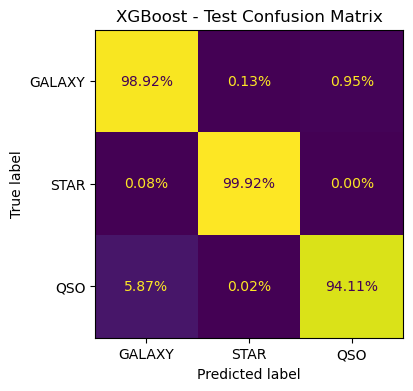

In [79]:
# makes predictions on test data
predictions = xgb_model.predict(x_cls_test)
truths = y_cls_test

# macro F1 score and balanced accuracy on test data
f1_macro = f1_score(truths, predictions, average='macro')
accuracy = bal_accuracy(truths, predictions)

print(f1_macro, accuracy)

# confusion matrix for test data
c_mat = confusion_matrix(truths, predictions, normalize='true')

# updates test table
testTableUpdate(model_id, accuracy, f1_macro, c_mat)

fig, axs = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=c_mat, display_labels=cls_dict.keys())
disp.plot(values_format='.2%', ax = axs)
disp.ax_.set_title('XGBoost - Test Confusion Matrix')
disp.im_.colorbar.remove()
plt.show()

## Neural Network - Multilayer Perceptron

### DataLoader and Helper Functions

In [80]:
# sets batch size for deep learning
dl_batch_size = 2048

# sets number of subprocesses (max logical thread)
dl_subproc = 20

# sets persistent workers flag True can significantly speed up training but it will
# increases RAM usage because the workers remain active even when not actively being used.
dl_pers_work = True

# sets pin memory flag to allocate data on the GPU's dedicated memory 
# which is faster than system memory -> faster training.
# However, it requires sufficient GPU memory to accommodate the pinned data.
dl_pin_mem = True

# fixed seed for reproducibility
torch.manual_seed(seed)

# converts training data to PyTorch tensor
x_cls_train_pt = torch.tensor(x_cls_train).float()
y_cls_train_pt = torch.tensor(y_cls_train).long()

dl_train = None
dl_valid = None

# function to create data loaders for k-fold cross-validation
def DLforKFold(train_idx, valid_idx, show_data=False):  
    # splits training data into training and validation sets
    x_train, y_train = x_cls_train_pt[train_idx], y_cls_train_pt[train_idx]
    x_valid, y_valid = x_cls_train_pt[valid_idx], y_cls_train_pt[valid_idx]

    # displays class distribution if show_data is True
    if show_data:
        display(pd.DataFrame(y_train.numpy()).iloc[:,0].map(df_cls_dict).value_counts().to_frame().style.bar(color='green'))
        display(pd.DataFrame(y_valid.numpy()).iloc[:,0].map(df_cls_dict).value_counts().to_frame().style.bar(color='green'))
    
    ds_train = TensorDataset(x_train, y_train)
    ds_valid = TensorDataset(x_valid, y_valid)

    global dl_train, dl_valid
    
    # shuts down persistent workers if they exist
    if dl_pers_work:
        if hasattr(dl_train, '_iterator'): 
            if dl_train._iterator is not None:
                dl_train._iterator._shutdown_workers()

        if hasattr(dl_valid, '_iterator'):
            if dl_valid._iterator is not None:
                dl_valid._iterator._shutdown_workers()
        
    # creates DataLoader for training data
    dl_train = DataLoader(ds_train, batch_size = dl_batch_size, 
                          shuffle = True, num_workers = dl_subproc, 
                          drop_last = True, pin_memory = dl_pin_mem,
                          persistent_workers = dl_pers_work)
    
    # creates DataLoader for validation data
    dl_valid = DataLoader(ds_valid, batch_size = dl_batch_size*2, 
                          shuffle = True, num_workers = dl_subproc, 
                          drop_last = True, pin_memory = dl_pin_mem,
                          persistent_workers = dl_pers_work)
    
# creates DataLoader for test data
x_cls_test_pt = torch.tensor(x_cls_test).float()
y_cls_test_pt = torch.tensor(y_cls_test).long()
ds_cls_test = TensorDataset(x_cls_test_pt, y_cls_test_pt)
dl_cls_test = DataLoader(ds_cls_test, batch_size = dl_batch_size, 
                         shuffle = True, num_workers = dl_subproc, 
                         drop_last = True, pin_memory = False,
                         persistent_workers = dl_pers_work)

print(f"train-valid size: {int(x_cls_train_pt.shape[0]/dl_batch_size)}\ntest size: {len(dl_cls_test)}")

train-valid size: 1635
test size: 545


In [81]:
# defines a class to store torch model
class ModelCheckpoint:
    # best_loss: Initial best loss (default: infinity)
    # file_name: File name for saving the model (default: 'best_model')
    def __init__(self, best_loss=float('inf'), file_name='best_model'): 
        self.best_loss_value = best_loss
        self.file_name = file_name
        self.last_epoch = 1e10
        
    # Called after each epoch to save the best model
    # epoch: Current epoch
    # model, optimizer, criterion: Training objects
    # current_loss_value: Current epoch loss
    # verbose: Print save message
    def __call__(self, epoch, model, optimizer, criterion, current_loss_value, verbose=False):
        if current_loss_value < self.best_loss_value:
            self.best_loss_value = current_loss_value
            self.last_epoch = epoch
            
            if verbose:
                print('\033[01m' + f"--- Best loss: {self.best_loss_value} - saving best model for epoch: {epoch+1}" + '\033[0m')

            torch.save({'model': model,
                        'epoch': epoch+1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': criterion,
                        'loss_value' : current_loss_value
                        }, self.file_name + '.pt')
        
    # loads the best model and loss value from the checkpoint file
    def load_model(self):
        checkpoint = torch.load(self.file_name + '.pt')
        return checkpoint['loss_value'], checkpoint['model']

    # resumes training from the saved checkpoint
    def resume(self, model, optimizer):
        checkpoint = torch.load(self.file_name + '.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['loss_value']
        
    # resets the last epoch value
    def resetBestEpoch(self):
        self.last_epoch = 1e10       

In [83]:
# defines a function to train NN model
def train_model(nn_model, model_id, initial_lr, final_lr, n_epochs, n_fold, patience=10, verbose=False):
    # initializes lists to store training history
    hist_loss = []
    hist_metric = []
    hist_vloss = []
    hist_vmetric = []
    epoch_times = []
    
    # creates an array of learning rates for each fold
    initial_lrs = np.linspace(initial_lr, final_lr, n_fold)
    
    # defines the loss function (crossentropy loss for classification)
    criterion = nn.CrossEntropyLoss()
    
    # defines the evaluation metric (accuracy for multiclass classification)
    metric = Accuracy(task = "multiclass", num_classes = 3)
    metric = metric.to(device) 
    
    # accesses global data loaders (training and validation)
    global dl_train, dl_valid

    # creates a stratifiedkfold object for cross-validation
    kf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
    
    # iterates through each fold of the cross-validation
    for fold, (train_idx, valid_idx) in enumerate(kf.split(x_cls_train_pt, y_cls_train_pt)):
        print('\033[01m' + f"\nStarting fold number {fold+1}" + '\033[0m')   

        # creates an Adam optimizer for the current fold
        opt = optim.Adam(nn_model.parameters(), lr = initial_lrs[fold], weight_decay=1e-5)
    
        # defines scheduler for the learning rate
        # scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, n_epochs, 1e-10)
        scheduler = optim.lr_scheduler.ExponentialLR(opt, 0.9)
        
        # resets the best epoch counter and initializes early stopping
        checkpointer.resetBestEpoch()
        patience_triggered = False
        
        # creates data loaders for the current fold
        DLforKFold(train_idx, valid_idx)
       
        # loops through each epoch of training
        for epoch in range(n_epochs):
            t0 = time.time()
            
            # sets the model to training mode
            nn_model.train()
            
            # initializes variables to accumulate training loss and metric
            train_loss = 0
            train_metric = 0
            
            # initializes a counter for the number of batches processed
            counter = 0
      
            # loops through each batch in the training data loader
            for i, (xb, yb) in enumerate(dl_train):
                counter += 1
                
                # zeros the gradients of the optimizer
                opt.zero_grad() 
                
                # moves the mini-batch of data to the device (cpu or gpu)
                xb = xb.to(device) 
                yb = yb.to(device)
                
                # performs a forward pass through the model
                pred = nn_model(xb) 
                
                # calculates the loss and metric
                tloss = criterion(pred, yb)
                tmetric = metric(pred, yb)
                
                # accumulates the training loss and metric
                train_loss += tloss.item()
                train_metric += tmetric.item()
    
                # performs backpropagation to calculate gradients
                tloss.backward()           
                # updates the models weights using the optimizer
                opt.step()       
    
            # appends the average training loss and metric to the history lists
            train_loss /= counter
            hist_loss.append(train_loss)
            train_metric /= counter
            hist_metric.append(train_metric)
            
            # sets the model to evaluation mode
            nn_model.eval()
            
            # initializes variables to accumulate validation loss and metric
            valid_loss = 0
            valid_metric = 0
            
            counter = 0
            
            # disables gradient calculation during validation
            with torch.no_grad():
                # loops through each batch in the validation data loader
                for xb, yb in dl_valid:
                    counter += 1
                    
                    # moves the mini-batch of data to the device (cpu or gpu)
                    xb = xb.to(device)
                    yb = yb.to(device)
                    
                    # performs a prediction with the network trained
                    pred = nn_model(xb)
                      
                    # calculates the loss and metric
                    vloss = criterion(pred, yb)
                    vmetric = metric(pred, yb)   
                    valid_loss += vloss.item()
                    valid_metric += vmetric.item()
            
            # appends the average validation loss and metric to the history lists      
            valid_loss /= counter
            hist_vloss.append(valid_loss)
            valid_metric /= counter
            hist_vmetric.append(valid_metric)
            
            # end of the epoch
            elapsed_time = time.time()-t0
            epoch_times.append(elapsed_time)
            
            # prints the epoch information if True
            if verbose:
                print(f"epoch: %{len(str(n_epochs))}d | time(s): %.1f | Metric = train: %.4f - valid: %.4f | Loss = train: %.4f - valid: %.4f | lr={scheduler.get_last_lr()[0]:.2e}"
                      % (epoch+1, elapsed_time, train_metric, valid_metric, train_loss, valid_loss))
                #print(f'learning rate: {scheduler.get_last_lr()[-1]}')
            else:
              print(f"running epoch: %{len(str(n_epochs))}d" % (epoch+1))         
    
            # checks if early stopping criteria are met
            if (epoch - checkpointer.last_epoch) >= patience:            
                # restores the model from the best checkpoint
                bloss = checkpointer.resume(nn_model, opt)
                
                # resets the last epoch counter
                checkpointer.resetBestEpoch()
                
                # sets the early stopping flag to true
                if patience_triggered:
                    print('\033[01m' + f"--- Early stopping triggered at epoch {epoch+1}. Loading best model with valid loss={bloss}." + '\033[0m')               
                    break
                else:
                    print('\033[01m' + f"--- Patience triggered at epoch {epoch+1}. Loading best model with valid loss={bloss}." + '\033[0m')                         
                    patience_triggered = True
                    continue
            
            # updates learning rate schedule
            scheduler.step(epoch+1)
            # saves best loss model
            checkpointer(epoch, nn_model, opt, criterion, valid_loss, verbose)
            
            # updates train table
            trainTableUpdate(model_id, np.array(epoch_times).sum(), train_metric, valid_metric, train_loss, valid_loss) 
            
    # returns the list of epoch times
    return epoch_times

In [100]:
def test_model(model_id, model_name):
    # loads the best performing model and its associated loss from the checkpoint
    checkpoint_loss, model = checkpointer.load_model()
    model.eval() 
    model.to(device)
    
    loss = 0
    metric = 0
    counter = 0
    
    predictions = np.empty(shape=(0,),dtype=int)
    truths = np.empty(shape=(0,),dtype=int)
    
    # disables gradient calculation for inference
    with torch.no_grad(): 
      for xb, yb in dl_cls_test:
        counter += 1
        xb=xb.to(device)
        yb=yb.type(torch.LongTensor).to(device)
    
        pred = model(xb)
    
        pred = pred.cpu()
        yb = yb.cpu()
          
        # calculates predicted class labels
        res = torch.argmax(pred, dim=1)
    
        predictions = np.concatenate((predictions,res.detach().numpy()))
        truths = np.concatenate((truths,yb.detach().numpy()))
    
    # macro F1 score and balanced accuracy on test data
    f1_macro = f1_score(truths, predictions, average='macro')
    accuracy = bal_accuracy(truths, predictions)
    
    # confusion matrix for test data
    c_mat = confusion_matrix(truths, predictions, normalize='true')
    
    # updates test table
    testTableUpdate(model_id, accuracy, f1_macro, c_mat)
    
    fig, axs = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=c_mat, display_labels=cls_dict.keys())
    disp.plot(values_format='.2%', ax = axs)
    disp.ax_.set_title(model_name + ' - Test Confusion Matrix')
    disp.im_.colorbar.remove()
    plt.show()
    print('model loss: ', checkpoint_loss)

### Model Architecture

In [84]:
# Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=3, dropout=0.2):
        super(MLP, self).__init__()
        # dim fractions were used to test the optimal
        # MLP architecture, but now are no longer used
        half_hdim = hidden_dim // 2
        quarter_hdim = hidden_dim // 4

        self.dense_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
        
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
        
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
        
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        x = self.dense_layers(x)
        return x

#### Summary test

In [29]:
mlp_model = MLP(input_dim = x_cls_train.shape[1], hidden_dim = 1024, dropout = 0.3)

mlp_model.to(device)

# prints the MLP model architecture, including layer sizes and parameter counts
print(summary(mlp_model, input_size=(1, x_cls_train.shape[1]), device=device))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 3]                    --
├─Sequential: 1-1                        [1, 3]                    --
│    └─Linear: 2-1                       [1, 1024]                 12,288
│    └─BatchNorm1d: 2-2                  [1, 1024]                 2,048
│    └─LeakyReLU: 2-3                    [1, 1024]                 --
│    └─Dropout: 2-4                      [1, 1024]                 --
│    └─Linear: 2-5                       [1, 1024]                 1,049,600
│    └─BatchNorm1d: 2-6                  [1, 1024]                 2,048
│    └─LeakyReLU: 2-7                    [1, 1024]                 --
│    └─Dropout: 2-8                      [1, 1024]                 --
│    └─Linear: 2-9                       [1, 1024]                 1,049,600
│    └─BatchNorm1d: 2-10                 [1, 1024]                 2,048
│    └─LeakyReLU: 2-11                   [1, 1024]        

### Train

In [30]:
# sets model ID for train, measure and test tables
model_id = 2

# sets train parameters
n_epochs = 20
n_folds = 8
patience = 5

# model checkpoint
checkpointer = ModelCheckpoint(0.06, "fnn_best_model")

# starts hardware monitoring
hw_monitor.start_monitoring()

# trains the model using the train_model function
epoch_times = train_model(nn_model = mlp_model,
                          model_id = model_id,
                          initial_lr = 5e-4,
                          final_lr = 5e-8,
                          n_epochs = n_epochs, 
                          n_fold = n_folds,
                          patience = patience,
                          verbose = True)

# stops hardware monitoring and updates measure table
hw_monitor.stop_monitoring()
hw_data = hw_monitor.get_stats() 
measureTableUpdate(model_id, hw_data)
    
print(f"\naverage time: {np.array(epoch_times).mean():.2f} ± {np.array(epoch_times).std():.2f} ms")
print(f"\ntotal time: {np.array(epoch_times).sum():.2f} s")


Starting fold number 1
epoch:  1 | time(s): 21.9 | Metric = train: 0.9714 - valid: 0.9762 | Loss = train: 0.0892 - valid: 0.0732 | lr=5.00e-04
epoch:  2 | time(s): 14.1 | Metric = train: 0.9759 - valid: 0.9774 | Loss = train: 0.0747 - valid: 0.0693 | lr=4.50e-04
epoch:  3 | time(s): 14.1 | Metric = train: 0.9771 - valid: 0.9789 | Loss = train: 0.0703 - valid: 0.0652 | lr=4.05e-04
epoch:  4 | time(s): 14.1 | Metric = train: 0.9780 - valid: 0.9795 | Loss = train: 0.0674 - valid: 0.0630 | lr=3.65e-04
epoch:  5 | time(s): 14.2 | Metric = train: 0.9787 - valid: 0.9800 | Loss = train: 0.0652 - valid: 0.0613 | lr=3.28e-04
epoch:  6 | time(s): 14.1 | Metric = train: 0.9792 - valid: 0.9806 | Loss = train: 0.0634 - valid: 0.0591 | lr=2.95e-04
--- Best loss: 0.059071143176041396 - saving best model for epoch: 6
epoch:  7 | time(s): 14.2 | Metric = train: 0.9797 - valid: 0.9805 | Loss = train: 0.0618 - valid: 0.0597 | lr=2.66e-04
epoch:  8 | time(s): 14.3 | Metric = train: 0.9801 - valid: 0.9801 

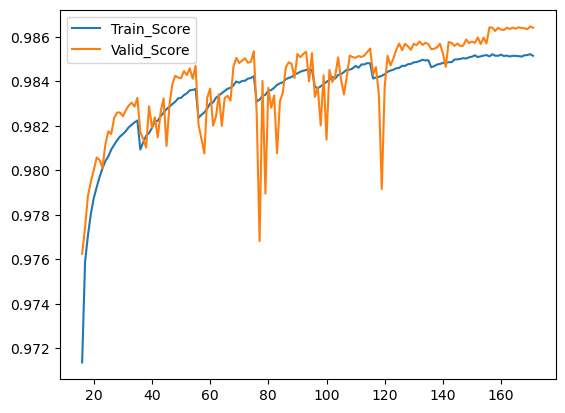

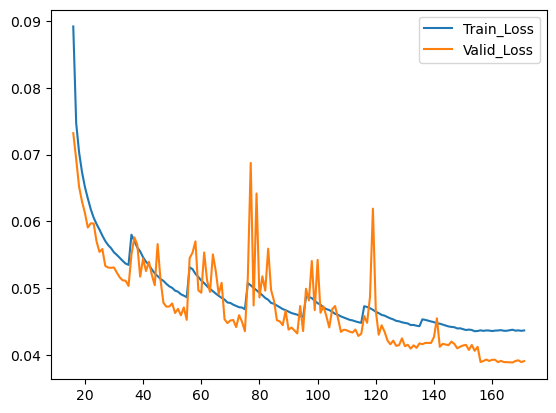

In [32]:
# plots train and validation loss/metric curves
train_table[ train_table.Model_ID == model_id ][['Train_Score', 'Valid_Score']].plot()
plt.show()
train_table[ train_table.Model_ID == model_id ][['Train_Loss', 'Valid_Loss']].plot()
plt.show()

### Test

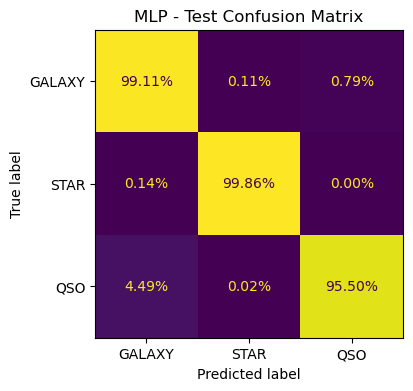

model loss:  0.03884261404620666


In [102]:
test_model(model_id, "MLP")

## Neural Network - Tabular Transformer

### Model Architecture

In [106]:
class ColumnEmbedding(nn.Module):
    def __init__(self, dim_embedding):
        super(ColumnEmbedding, self).__init__()
        self.embedding = nn.Linear(1, dim_embedding)

    def forward(self, x):
        # x shape: (batch_size, num_continuous)
        x = x.unsqueeze(-1)  # shape: (batch_size, num_continuous, 1)
        return self.embedding(x)  # shape: (batch_size, num_continuous, dim_embedding)

class TransformerEncoder(nn.Module):
    def __init__(self, dim_embedding, nhead, num_layers, dropout):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=nhead, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.encoder(x)

class TabTransformer(nn.Module):
    def __init__(self, input_dim, dim_embedding=32, nhead=4, num_layers=2, hidden_dim=128, output_dim=3, dropout=0.2):
        super(TabTransformer, self).__init__()
        self.embedding = ColumnEmbedding(dim_embedding)
        self.transformer = TransformerEncoder(dim_embedding, nhead, num_layers, dropout)
        self.flatten_dim = input_dim * dim_embedding
        self.classifier = MLP(input_dim=self.flatten_dim, hidden_dim=hidden_dim, output_dim=output_dim, dropout=dropout)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, num_continuous, dim_embedding)
        x = self.transformer(x)  # (batch_size, num_continuous, dim_embedding)
        x = x.flatten(start_dim=1)  # (batch_size, num_continuous * dim_embedding)
        return self.classifier(x)

#### Summary test

In [35]:
tab_model = TabTransformer(input_dim = x_cls_train.shape[1], hidden_dim = 1024, dropout = 0.3)

tab_model.to(device)

# prints the TabTransformer model architecture, including layer sizes and parameter counts
print(summary(tab_model, input_size=(1, x_cls_train.shape[1]), device=device))

Layer (type:depth-idx)                             Output Shape              Param #
TabTransformer                                     [1, 3]                    --
├─ColumnEmbedding: 1-1                             [1, 11, 32]               --
│    └─Linear: 2-1                                 [1, 11, 32]               64
├─TransformerEncoder: 1-2                          [1, 11, 32]               --
│    └─TransformerEncoder: 2-2                     [1, 11, 32]               --
│    │    └─ModuleList: 3-1                        --                        275,008
├─MLP: 1-3                                         [1, 3]                    --
│    └─Sequential: 2-3                             [1, 3]                    --
│    │    └─Linear: 3-2                            [1, 1024]                 361,472
│    │    └─BatchNorm1d: 3-3                       [1, 1024]                 2,048
│    │    └─LeakyReLU: 3-4                         [1, 1024]                 --
│    │    └─Dropout: 3

### Train

In [36]:
# sets model ID for train, measure and test tables
model_id = 3

# sets train parameters
n_epochs = 20
n_folds = 8
patience = 5

# istanzia il save_best_model
checkpointer = ModelCheckpoint(0.06, "tab_best_model")

# starts hardware monitoring
hw_monitor.start_monitoring()

# trains the model using the train_model function
epoch_times = train_model(nn_model = tab_model,
                          model_id = model_id,
                          initial_lr = 5e-4,
                          final_lr = 5e-8,
                          n_epochs = n_epochs, 
                          n_fold = n_folds,
                          patience = patience,
                          verbose = True)

# stops hardware monitoring and updates measure table
hw_monitor.stop_monitoring()
hw_data = hw_monitor.get_stats() 
measureTableUpdate(model_id, hw_data)
    
print(f"\naverage time: {np.array(epoch_times).mean():.2f} ± {np.array(epoch_times).std():.2f} ms")
print(f"\ntotal time: {np.array(epoch_times).sum():.2f} s")


Starting fold number 1
epoch:  1 | time(s): 79.3 | Metric = train: 0.9632 - valid: 0.9624 | Loss = train: 0.1097 - valid: 0.1023 | lr=5.00e-04
epoch:  2 | time(s): 70.7 | Metric = train: 0.9749 - valid: 0.9762 | Loss = train: 0.0782 - valid: 0.0759 | lr=4.50e-04
epoch:  3 | time(s): 70.5 | Metric = train: 0.9772 - valid: 0.9784 | Loss = train: 0.0713 - valid: 0.0671 | lr=4.05e-04
epoch:  4 | time(s): 70.6 | Metric = train: 0.9783 - valid: 0.9795 | Loss = train: 0.0672 - valid: 0.0643 | lr=3.65e-04
epoch:  5 | time(s): 70.6 | Metric = train: 0.9787 - valid: 0.9803 | Loss = train: 0.0656 - valid: 0.0606 | lr=3.28e-04
epoch:  6 | time(s): 70.7 | Metric = train: 0.9795 - valid: 0.9800 | Loss = train: 0.0633 - valid: 0.0607 | lr=2.95e-04
epoch:  7 | time(s): 70.6 | Metric = train: 0.9798 - valid: 0.9808 | Loss = train: 0.0620 - valid: 0.0596 | lr=2.66e-04
--- Best loss: 0.05955297174845256 - saving best model for epoch: 7
epoch:  8 | time(s): 70.6 | Metric = train: 0.9802 - valid: 0.9811 |

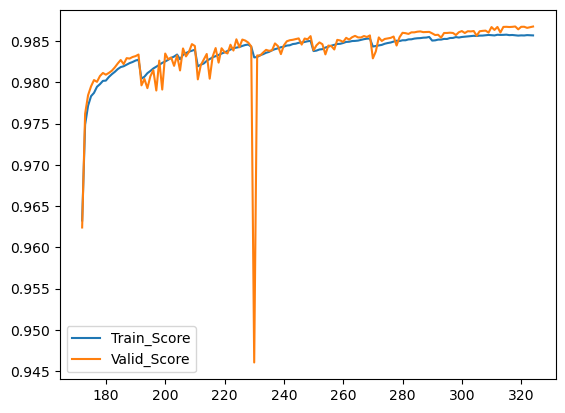

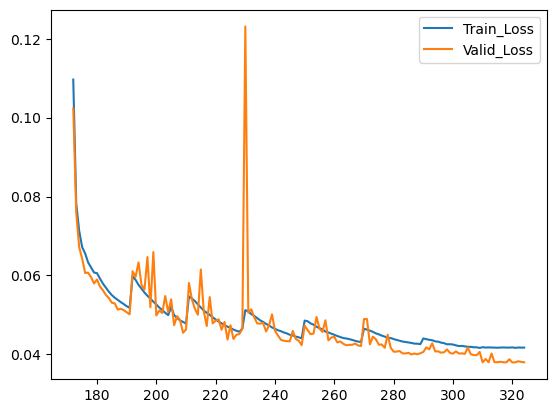

In [91]:
# plots train and validation loss/metric curves
train_table[ train_table.Model_ID == model_id ][['Train_Score', 'Valid_Score']].plot()
plt.show()
train_table[ train_table.Model_ID == model_id ][['Train_Loss', 'Valid_Loss']].plot()
plt.show()

### Test

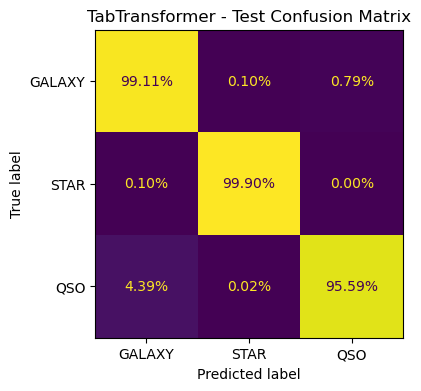

model loss:  0.03794992483202733


In [107]:
test_model(model_id, "TabTransformer")

# Tables Operations

In [38]:
# saves all tables
train_table.to_csv('train_table.csv', index=False)
measure_table.to_csv('measure_table.csv', index=False)
test_table.to_csv('test_table.csv', index=False)

## Fitting metrics for future forecasting

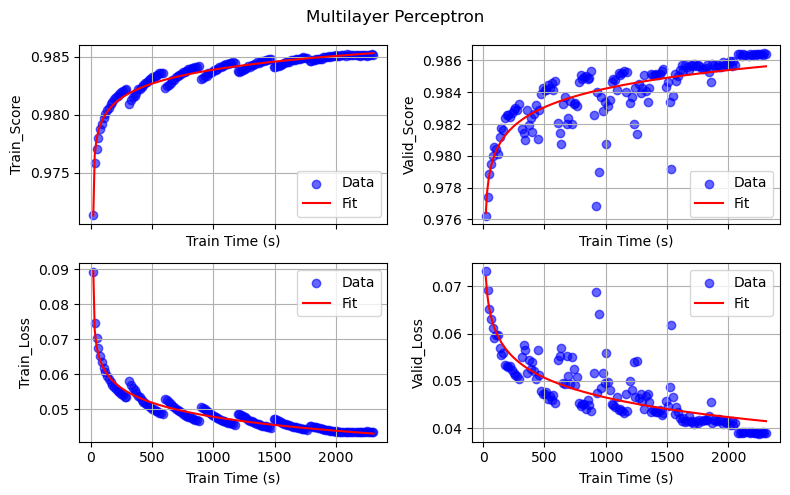

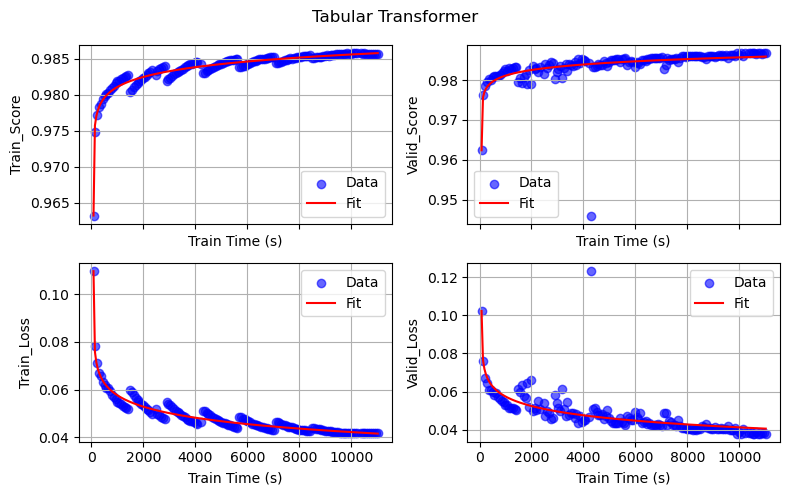

In [5]:
# load tables
train_table = pd.read_csv("train_table.csv")
model_table = pd.read_csv("model_table.csv")

fit_params = []
# log-like fitting function 
def log_fn(t, a, b, c):
    return a * np.log(t + b) + c

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    for model in train_table.Model_ID.unique()[2:]:
        
        fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True)
        fig.suptitle(model_table[ model_table.Model_ID == model].Model_Name.values[0])
        
        for idx, metric in enumerate(list(train_table.columns[-4:])):       
            ax = axes[idx // 2, idx % 2]
            
            # sets x, y for fitting
            x = train_table[train_table.Model_ID == model]['Train_Time'].values
            y = train_table[train_table.Model_ID == model][metric].values
            
            # curve fit
            params, _ = curve_fit(log_fn, x, y)
            
            # fitted curve with exstimated params
            x_fit = np.linspace(x.min(), x.max(), 200)
            y_fit = log_fn(x_fit, *params)
            
            # Plot
            ax.scatter(x, y, label="Data", color='blue', alpha=0.6)
            ax.plot(x_fit, y_fit, label="Fit", color='red')
            ax.set_xlabel("Train Time (s)")
            ax.set_ylabel(metric)
            ax.legend()
            ax.grid(True)
            
            fit_params.append({
                'Model_ID': model,
                'Metric': metric,
                'a': params[0],
                'b': params[1],
                'c': params[2]
            })
            
        plt.tight_layout()
        plt.show()
# saves params on a table for each models and metrics
pd.DataFrame(fit_params).to_csv('log_prev_table.csv', index=False)        